# NDB1 Analysis

In this notebook we analyse the results from NDB1 experiment (`script_06.py`).

We leverage [set intersection metrics](https://effectivesoftwaredesign.com/2019/02/27/data-science-set-similarity-metrics/).

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.datasets as datasets
from NegativeClassOptimization import config, preprocessing, ml

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## (Experiment ID=2, script_06) NDB1 with no hyperparameter tuning

In [18]:
df2 = pd.read_csv(
    "../data/mlflow_experiment2_runs.tsv", 
    sep='\t',
    dtype={"ag_pos": str, "ag_neg": str}
    )
df2["ag_pos"] = df2["ag_pos"].replace("5E+094", "5E94")
df2["ag_neg"] = df2["ag_neg"].replace("5E+094", "5E94")
df2["ag_pair"] = df2["ag_pos"] + "_" + df2["ag_neg"]
df2 = df2.loc[df2["Name"] == "run_2"].iloc[:15]
df2["test_acc"] = df2["test_acc"] / 100
print(df2.shape)
print(df2.columns)
df2.head(2)

(15, 28)
Index(['Start Time', 'Duration', 'Run ID', 'Name', 'Source Type',
       'Source Name', 'User', 'Status', 'N_closed', 'N_open', 'N_train',
       'ag_neg', 'ag_pos', 'batch_size', 'epochs', 'learning_rate', 'momentum',
       'optimizer_type', 'weight_decay', 'closed_f1', 'closed_precision',
       'closed_recall', 'closed_roc_auc', 'open_roc_auc', 'test_acc',
       'test_loss', 'train_loss', 'ag_pair'],
      dtype='object')


,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,N_closed,N_open,...,weight_decay,closed_f1,closed_precision,closed_recall,closed_roc_auc,open_roc_auc,test_acc,test_loss,train_loss,ag_pair
0,2022-09-14 18:22:51,50.0min,95e4894c7c894f628abf9e9c3f0cfe97,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,9223.0,131283.0,...,0.0,0.962009,0.952649,0.971555,0.993635,0.664040,0.962268,0.141685,0.056483,1NSN_5E94
1,2022-09-14 18:22:51,49.1min,e3bc390261234ba497938506f197d738,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,8968.0,131283.0,...,0.0,0.980407,0.982491,0.978331,0.998349,0.764058,0.982493,0.097108,0.000223,1FBI_1OB1


In [19]:
compairr = pd.read_csv("../data/CompAIRR/results/overlaps_d1_output.tsv", sep='\t', index_col=0)
compairr

,1ADQ,1FBI,1H0D,1NSN,1OB1,1WEJ,2YPV,3RAJ,3VRL,5E94,OPENSET
#,,,,,,,,,,,
1ADQ,108197,2763,4036,2521,3100,3112,3872,7331,7957,4899,117186
1FBI,2763,135298,1631,3493,8600,13111,4282,3768,4304,11708,11386
1H0D,4036,1631,165873,3895,378,2512,30477,7965,5906,10339,180466
1NSN,2521,3493,3895,170687,30603,6606,1524,3608,11573,15259,10689
1OB1,3100,8600,378,30603,182923,11764,2045,2209,15462,31647,7400
1WEJ,3112,13111,2512,6606,11764,171387,2388,8193,29120,32231,15077
2YPV,3872,4282,30477,1524,2045,2388,176120,9292,7504,11709,189257
3RAJ,7331,3768,7965,3608,2209,8193,9292,81101,3747,8802,93120
3VRL,7957,4304,5906,11573,15462,29120,7504,3747,212995,24202,23042


In [20]:
def jaccard_index(
    ag1: str, 
    ag2: str, 
    pairwise: pd.DataFrame = compairr
    ) -> float:
    intersection = pairwise.loc[ag1, ag2]
    union = (
        pairwise.loc[ag1, ag1] 
        + pairwise.loc[ag2, ag2] 
        - intersection
    )
    return intersection / union

jaccard_index("1ADQ", "5E94")

0.015961242103274025

In [21]:
df2["jaccard_pos_neg"] = df2.apply(lambda s: jaccard_index(s["ag_pos"], s["ag_neg"]), axis=1)
df2["jaccard_pos_openset"] = df2.apply(lambda s: jaccard_index(s["ag_pos"], "OPENSET"), axis=1)
df2["jaccard_neg_openset"] = df2.apply(lambda s: jaccard_index(s["ag_neg"], "OPENSET"), axis=1)
df2["jaccard_closed_openset_sum"] = df2["jaccard_pos_openset"] + df2["jaccard_neg_openset"]

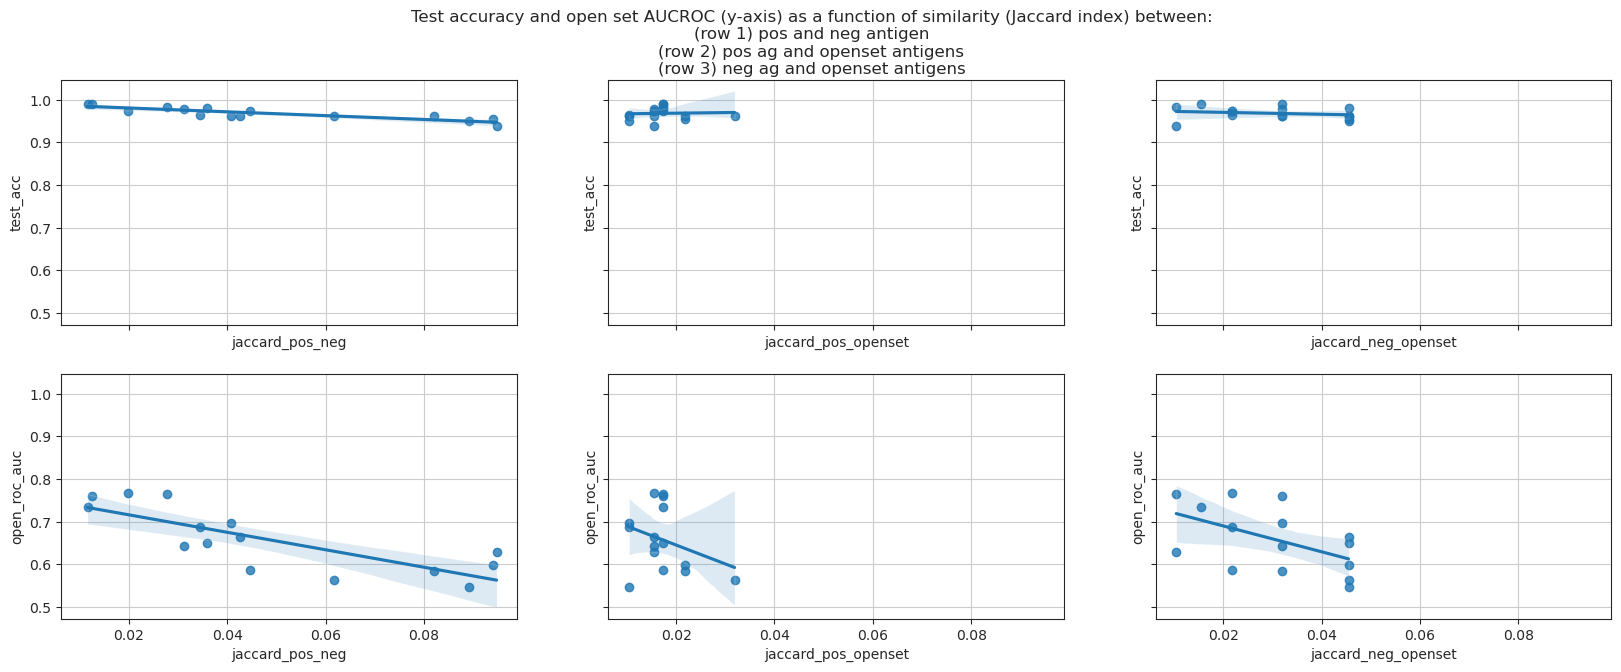

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 7), sharex=True, sharey=True)

sns.regplot(data=df2, x="jaccard_pos_neg", y="test_acc", ax=axs[0][0])
sns.regplot(data=df2, x="jaccard_pos_neg", y="open_roc_auc", ax=axs[1][0])
sns.regplot(data=df2, x="jaccard_pos_openset", y="test_acc", ax=axs[0][1])
sns.regplot(data=df2, x="jaccard_pos_openset", y="open_roc_auc", ax=axs[1][1])
sns.regplot(data=df2, x="jaccard_neg_openset", y="test_acc", ax=axs[0][2])
sns.regplot(data=df2, x="jaccard_neg_openset", y="open_roc_auc", ax=axs[1][2])
# sns.regplot(data=df2, x="jaccard_closed_openset_sum", y="test_acc", ax=axs[3][0])
# sns.regplot(data=df2, x="jaccard_closed_openset_sum", y="open_roc_auc", ax=axs[3][1])

plt.suptitle(
    "Test accuracy and open set AUCROC (y-axis) "
    "as a function of similarity (Jaccard index) between:\n"
    "(row 1) pos and neg antigen\n"
    "(row 2) pos ag and openset antigens\n"
    "(row 3) neg ag and openset antigens\n"
    # "(row 4) sum of (2) and (3)"
);

## (Experiment ID=3, script_06b) NDB1 with hyperparameter tuning

Hypotheses:
1. does openset roc improve with closedset roc due to cross-validation?
    - for each ag_pair, there is some relation between `closed_roc_auc` and `open_roc_auc`.
    - with time (optuna), the closed performance improves, wil the open performance does not.
    - do the tuned models perform better on the open set than untuned (from experiment ID=2)?
        - currently no, but there was an important difference: SGD vs Adam optimizer. Rerunning stage_06 to have meaningful comparison.
        - after both are with Adam, the actual results for open_roc_auc improved, not exactly clear why. It would also be useful to have the val accuracy maybe?

In [23]:
df = pd.read_csv("../data/mlflow_experiment3_runs.tsv", sep='\t')
df["ag_pos"] = df["ag_pos"].replace("5E+094", "5E94")
df["ag_neg"] = df["ag_neg"].replace("5E+094", "5E94")
df["ag_pair"] = df["ag_pos"] + "_" + df["ag_neg"]
df["Start Time"] = pd.to_datetime(df["Start Time"])
df["test_acc"] /= 100
print(df.columns.tolist())
df.head(3)

['Start Time', 'Duration', 'Run ID', 'Name', 'Source Type', 'Source Name', 'User', 'Status', 'N_closed', 'N_open', 'N_train', 'N_val', 'ag_neg', 'ag_pos', 'batch_size', 'epochs', 'learning_rate', 'momentum', 'optimizer_type', 'weight_decay', 'closed_f1', 'closed_precision', 'closed_recall', 'closed_roc_auc', 'open_roc_auc', 'test_acc', 'test_loss', 'train_loss', 'val_acc', 'val_f1', 'val_loss', 'val_precision', 'val_recall', 'val_roc_auc', 'ag_pair']


,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,N_closed,N_open,...,test_acc,test_loss,train_loss,val_acc,val_f1,val_loss,val_precision,val_recall,val_roc_auc,ag_pair
0,2022-09-14 13:02:39,29.2min,1b8ad99089814b2a87147c3fb32dd6f8,run_1_val,LOCAL,scripts/script_06b_SN10_NDB1_crossval.py,eugen,FINISHED,9577,131283,...,0.009645,NaN,0.081093,96.496101,0.966537,0.146306,0.981965,0.951587,0.993848,1OB1_3VRL
1,2022-09-14 12:55:42,28.9min,83c0a83ddd794244b16da0af82f101e8,run_1_val,LOCAL,scripts/script_06b_SN10_NDB1_crossval.py,eugen,FINISHED,9240,131283,...,0.009574,NaN,0.141289,95.645091,0.955528,0.131838,0.968090,0.943289,0.992099,3VRL_5E94
2,2022-09-14 12:54:57,29.5min,75f9ad01e770493fac2f88b7e7e7b0ec,run_1_val,LOCAL,scripts/script_06b_SN10_NDB1_crossval.py,eugen,FINISHED,9064,131283,...,0.009704,NaN,0.081102,96.912752,0.968954,0.083145,0.975538,0.962458,0.995720,1NSN_3VRL


In [24]:
tuned_runs_mask = df["Name"].str.split("_").str[-1] != "val"
df_tuned = df.loc[tuned_runs_mask].copy()
df_cv = df.loc[~tuned_runs_mask].copy()
print(f"""
    {df_tuned.shape}, {df_cv.shape}
""")


    (15, 35), (450, 35)



/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


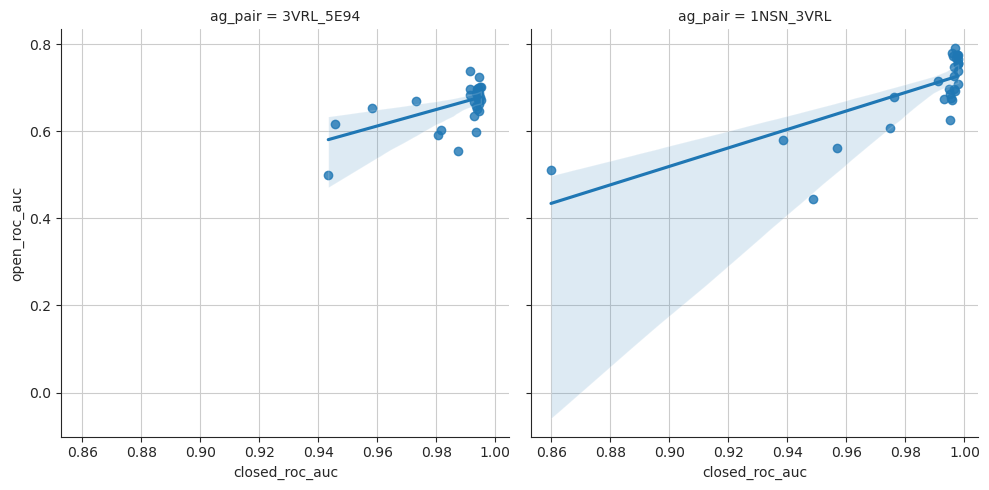

In [17]:
# sns.set_style("ticks",{'axes.grid' : True})
# sns.lmplot(
#     data=df_cv,
#     x="closed_roc_auc",
#     y="open_roc_auc",
#     col="ag_pair",
#     col_wrap=5,
#     height=5,
#     sharex=True,
#     # ci=None,
#     robust=True,
# )

df_cv = df_cv.loc[df_cv["ag_pair"].isin(["3VRL_5E94", "1NSN_3VRL"])].copy()
sns.set_style("ticks",{'axes.grid' : True})
sns.lmplot(
    data=df_cv,
    x="closed_roc_auc",
    y="open_roc_auc",
    col="ag_pair",
    # col_wrap=5,
    # height=5,
    sharex=True,
    # ci=None,
    robust=True,
)

<AxesSubplot:xlabel='Start Time', ylabel='closed_roc_auc'>

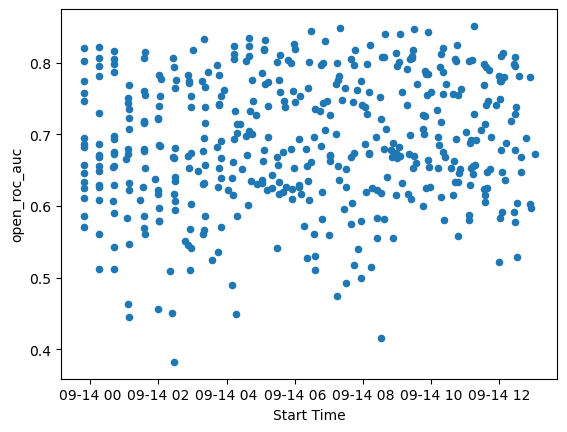

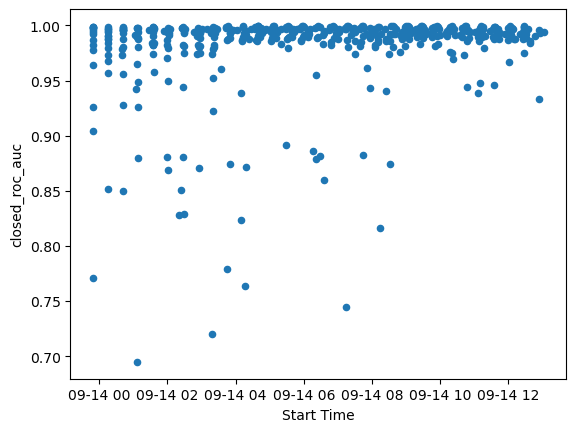

In [9]:
df_cv.plot.scatter(x="Start Time", y="open_roc_auc")
df_cv.plot.scatter(x="Start Time", y="closed_roc_auc")

In [9]:
assert set(df2.ag_pair) == set(df_tuned.ag_pair)
df2["experiment_id"] = "2"
df_tuned["experiment_id"] = "3"
df = pd.concat((df2, df_tuned), axis=0)
df.head()

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,N_closed,N_open,...,jaccard_neg_openset,jaccard_closed_openset_sum,experiment_id,N_val,val_acc,val_f1,val_loss,val_precision,val_recall,val_roc_auc
0,2022-09-14 18:22:51,50.0min,95e4894c7c894f628abf9e9c3f0cfe97,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,9223.0,131283.0,...,0.045487,0.060917,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-14 18:22:51,49.1min,e3bc390261234ba497938506f197d738,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,8968.0,131283.0,...,0.010448,0.027788,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-14 18:22:51,48.7min,4a4ea49a42644189b3909b14d4f18ec2,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,8595.0,131283.0,...,0.031884,0.049224,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-14 18:22:51,48.1min,9a477e5d165140568d7b4efac2d3efa7,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,8465.0,131283.0,...,0.015431,0.032771,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-14 18:22:51,50.0min,1cbe0e83b6c749cc9d250677b784c293,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,9240.0,131283.0,...,0.045487,0.077371,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# irrelevant as long as tuning doesn't help!
df_pivot = df.pivot(index="ag_pair", columns=["experiment_id"], values=["test_acc"])
df_pivot = df_pivot.reset_index(drop=False)
df_pivot.columns = df_pivot.columns.droplevel(0)
df_pivot.columns.name = None
df_pivot.columns = ["ag_pair", "untuned", "tuned"]
df_pivot

,ag_pair,untuned,tuned
0,1FBI_1NSN,0.990077,0.990195
1,1FBI_1OB1,0.982493,0.984389
2,1FBI_1WEJ,0.974229,0.977189
3,1FBI_3VRL,0.989180,0.991739
4,1FBI_5E94,0.979406,0.983203
5,1NSN_1OB1,0.937329,0.948853
6,1NSN_1WEJ,0.973908,0.978276
7,1NSN_3VRL,0.977493,0.979148
8,1NSN_5E94,0.962268,0.964003
9,1OB1_1WEJ,0.962814,0.961727


Text(0.5, 1.0, 'Closed set test accuracy for untuned vs tuned SN10.')

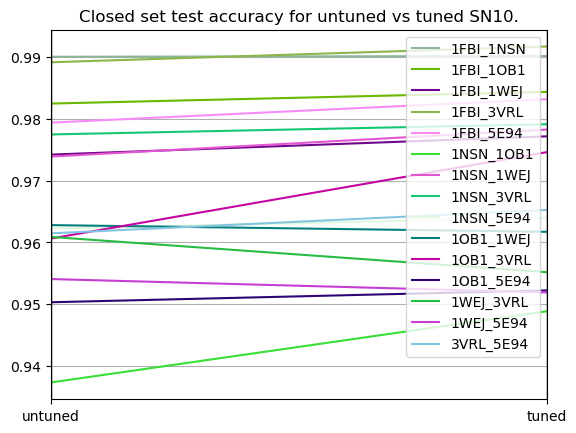

In [12]:
fig, ax = plt.subplots()
pd.plotting.parallel_coordinates(df_pivot, class_column="ag_pair", ax=ax)
ax.set_title("Closed set test accuracy for untuned vs tuned SN10.")

## NDB1 problem symmetry

We are interested in evaluating how are the results influenced when switching the positive antigen with the negative one. 

A priori, we don't expect a major change in results.

In [ ]:
N = 1000

epochs = 2
learning_rate = 0.01
ag_pos = "1FBI"
# ag_neg = "1NSN"
ag_neg = ["1NSN", "1OB1"]  # for NDBK

data_path = Path(config.DATA_SLACK_1_GLOBAL)

In [ ]:
processed_dfs: dict = ml.DataPipeline.load_processed_dataframes()
df_train_val = processed_dfs["train_val"]
df_train_val = df_train_val.loc[df_train_val["Antigen"].isin([ag_pos, *ag_neg])]
df_test_closed = processed_dfs["test_closed_exclusive"]
df_test_closed = df_test_closed.loc[df_test_closed["Antigen"].isin([ag_pos, *ag_neg])]
df_test_open = processed_dfs["test_open_exclusive"]
df_test_open = df_test_open.drop_duplicates(["Slide"], keep="first").reset_index(drop=True)

(   
    _,
    _,
    _,
    train_loader,
    test_loader,
    open_loader,
    ) = preprocessing.preprocess_data_for_pytorch_binary(
        df_train_val=df_train_val,
        df_test_closed=df_test_closed,
        ag_pos=[ag_pos],
        scale_onehot=True,
        df_test_open=df_test_open,
)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = ml.SN10().to(device)

online_metrics = ml.train_for_ndb1(epochs, learning_rate, train_loader, test_loader, open_loader, model)
online_metrics

In [ ]:
eval_metrics = ml.evaluate_on_closed_and_open_testsets(open_loader, test_loader, model)
eval_metrics

### From mlflow 06c

In [10]:
api = utils.MlflowAPI()
api.mlflow_request("8", "dev-v0.1.2-3")
df = api.build_mlflow_results_df()

df["ag_pos"] = list(map(lambda x: utils.extract_antigens_from_string(x)[0], df["ag_pos"]))
df["ag_neg"] = list(map(lambda x: utils.extract_antigens_from_string(x)[0], df["ag_neg"]))
df["ag_pair"] = df["ag_pos"] + "_" + df["ag_neg"]
df["ag_pair_sorted"] = df["ag_pair"].apply(lambda x: "_".join(sorted(x.split("_"))))

In [11]:
print(df.shape)
df.head(2)

(500, 44)


,optimizer_type,test_hash_key_0,ag_neg,test_hash_keys,num_samples_open,batch_size,epochs,N_open,num_samples_closed,N_closed,...,recall_closed,mlflow.source.git.commit,mlflow.note.content,mlflow.source.type,mlflow.runName,mlflow.source.name,mlflow.log-model.history,mlflow.user,ag_pair,ag_pair_sorted
0,Adam,4,3GI9,"[4, 5, 6]",10000,64,30,10000,30000,8420,...,0.948390,6ae68674908af49d3d4e9727661811f247479f29,"('4K9E_C', '3GI9_C')",LOCAL,dev-v0.1.2-3,scripts/script_06c_SN10_NDB1_asymmetry.py,"[{""run_id"": ""ce2f9b1d80844ffeaa380fdd082c259c""...",eugen,4K9E_3GI9,3GI9_4K9E
1,Adam,4,4K9E,"[4, 5, 6]",10000,64,30,10000,30000,8420,...,0.949098,6ae68674908af49d3d4e9727661811f247479f29,"('3GI9_C', '4K9E_C')",LOCAL,dev-v0.1.2-3,scripts/script_06c_SN10_NDB1_asymmetry.py,"[{""run_id"": ""edade441624346dc9a4a397481ed2972""...",eugen,3GI9_4K9E,3GI9_4K9E


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   optimizer_type            500 non-null    object 
 1   test_hash_key_0           500 non-null    object 
 2   ag_neg                    500 non-null    object 
 3   test_hash_keys            500 non-null    object 
 4   num_samples_open          500 non-null    object 
 5   batch_size                500 non-null    object 
 6   epochs                    500 non-null    object 
 7   N_open                    500 non-null    object 
 8   num_samples_closed        500 non-null    object 
 9   N_closed                  500 non-null    object 
 10  N_train                   500 non-null    object 
 11  ag_pos                    500 non-null    object 
 12  learning_rate             500 non-null    object 
 13  weight_decay              500 non-null    object 
 14  momentum  

<AxesSubplot:xlabel='f1_closed', ylabel='f1_open'>

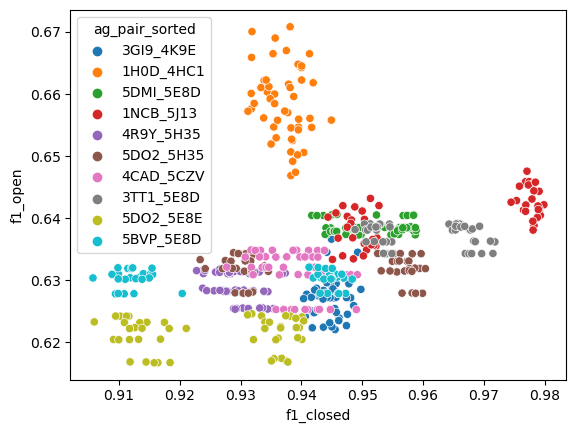

In [12]:
sns.scatterplot(
    data=df,
    x="f1_closed",
    y="f1_open",
    hue="ag_pair_sorted",
)

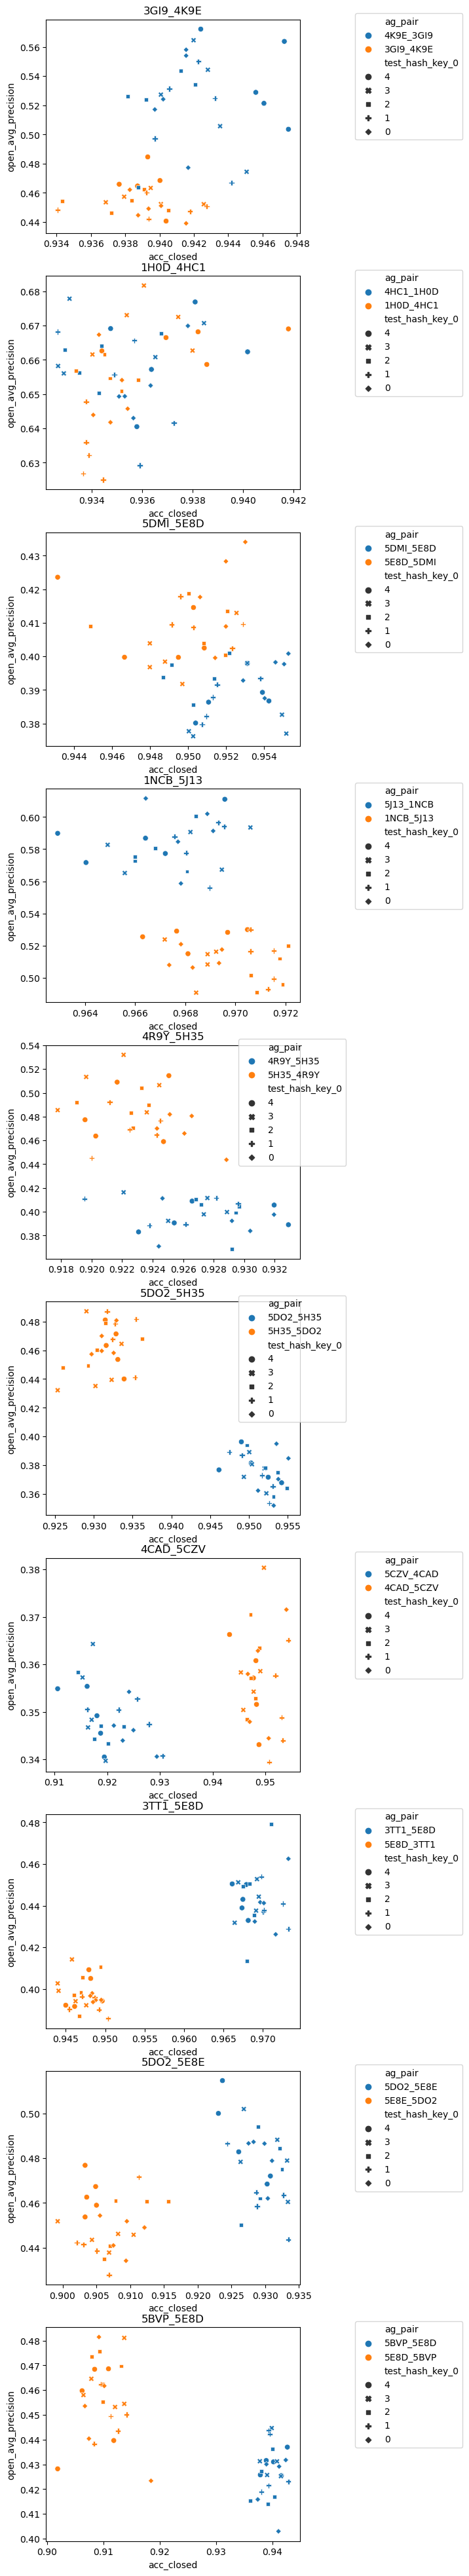

In [28]:
fig, axs = plt.subplots(nrows=10, figsize=(5, 50))

ag_pairs = df["ag_pair_sorted"].unique()
for i, ag_pair in enumerate(ag_pairs):
    sns.scatterplot(
        data=df.loc[df["ag_pair_sorted"] == ag_pair],
        x="acc_closed",
        y="open_avg_precision",  # open_f1
        hue="ag_pair",
        style="test_hash_key_0",
        ax=axs[i]
    )
    axs[i].set_title(ag_pair)
    axs[i].legend(bbox_to_anchor=(1.2, 1.05))

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


for i, ag_pair in enumerate(ag_pairs):
    dat = df.loc[df["ag_pair_sorted"] == ag_pair]
    # res = smf.ols('open_avg_precision ~ C(ag_pair) + C(test_hash_key_0) + C(rep)', data=dat).fit()
    res = smf.ols('acc_closed ~ C(ag_pair) + C(test_hash_key_0) + C(rep)', data=dat).fit()
    print(ag_pair)
    print(res.summary())

3GI9_4K9E
                            OLS Regression Results                            
Dep. Variable:             acc_closed   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     6.330
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           1.59e-05
Time:                        09:58:59   Log-Likelihood:                 245.28
No. Observations:                  50   AIC:                            -470.6
Df Residuals:                      40   BIC:                            -451.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       